## 0. Imports

In [1]:
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
import torch
import time
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from dataset import LoadDataset
from model import Generator, Discriminator
from train import train_generator, train_discriminator, evaluate
from settings import DEVICE, MEAN, STD, BATCH_SIZE, LATENT_SIZE, EPOCHS, LOSS_FN, OPTIMIZER, BETAS, D_LR, D_LR_DECAY, G_LR, G_LR_DECAY, CORES, LOAD_MODELS

torch.set_num_threads(4)

import autoreload
%load_ext autoreload
%autoreload 2

## 1. Dataset

In [2]:
ds = LoadDataset('../data/train', MEAN, STD)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=CORES)
num_batches = len(ds)/BATCH_SIZE

val_ds = LoadDataset('../data/val', MEAN, STD)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=CORES)

len(ds)

92032

## 2. Models

In [3]:
G, D = Generator(), Discriminator()
print(G)
print(D)
print(f"Num parameters in Discriminator: {sum(p.numel() for p in D.parameters())}")
print(f"Num parameters in Generator: {sum(p.numel() for p in G.parameters())}")

Generator(
  (upsampling): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


## 3. Training

In [4]:
d_losses = []
g_losses = []
r_scores = []
f_scores = []
d_optimizer = OPTIMIZER(D.parameters(), D_LR, betas=BETAS)
g_optimizer = OPTIMIZER(G.parameters(), G_LR, betas=BETAS)


try:
    if LOAD_MODELS:
        D.load_state_dict(torch.load('discriminator.pth'))
        G.load_state_dict(torch.load('generator.pth'))
        print("Model loaded")
    else:
        print("Trainning new model")
except:
    print("Trainning new model")
    pass

D.to(DEVICE)
G.to(DEVICE)

if not LOAD_MODELS:
    with open("log.json", "w") as fh:
        json.dump({"epochs": 0}, fh)
    start_epochs = 0
else:
    with open("log.json", "r") as fh:
        log = json.load(fh)
    start_epochs = log['epochs']
    for e in range(1, start_epochs+1):
        d_losses.append(log[str(e)]['d_loss'])
        g_losses.append(log[str(e)]['g_loss'])
        r_scores.append(log[str(e)]['r_score'])
        f_scores.append(log[str(e)]['f_score'])

    d_optimizer.param_groups[0]['lr'] -= D_LR_DECAY * start_epochs
    g_optimizer.param_groups[0]['lr'] -= G_LR_DECAY * start_epochs
    latent = torch.randn(BATCH_SIZE, *LATENT_SIZE).to(DEVICE)
    fake_images = G(latent)*0.5 + 0.5
    save_image(fake_images, 'current.png')
print(f"Start at epochs {start_epochs}")

Model loaded
Start at epochs 100


In [14]:
for epochs in range(start_epochs, EPOCHS):
    start = time.time()

    for batch_images in tqdm(loader):
        batch_images = batch_images.to(DEVICE)
        d_loss = train_discriminator(G, D, batch_images, LOSS_FN, d_optimizer, LATENT_SIZE, BATCH_SIZE, DEVICE)
        g_loss = train_generator(G, D, LOSS_FN, g_optimizer, LATENT_SIZE, BATCH_SIZE, DEVICE)
        
    d_loss, g_loss, r_score, f_score, fake_images = evaluate(G, D, LOSS_FN, val_loader, LATENT_SIZE, BATCH_SIZE, DEVICE)
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    r_scores.append(r_score)
    f_scores.append(f_score)
    torch.save(G.state_dict(), 'generator.pth')
    torch.save(D.state_dict(), 'discriminator.pth')
    
    d_loss = round(d_loss,5)
    g_loss = round(g_loss,5)
    r_score = round(r_score,5)
    f_score = round(f_score,5)

    d_optimizer.param_groups[0]['lr'] -= D_LR_DECAY
    g_optimizer.param_groups[0]['lr'] -= G_LR_DECAY

    elapsed = round(time.time()-start, 2)
    print(f"Epoch #{epochs+1}: d_loss={d_loss}, g_loss={g_loss}, r_score={r_score}, f_score={f_score} elapsed={elapsed} s")
    
    with open("log.json", "r") as fh:
        log = json.load(fh)
    log["epochs"] += 1
    log[epochs+1] = {"d_loss": d_loss, "g_loss": g_loss, "r_score": r_score, "f_score": f_score, "elapsed": elapsed}
    
    with open("log.json", "w") as fh:
        json.dump(log, fh)
    
    save_image(fake_images, f'output/{epochs+1}.png')

  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #65: d_loss=0.36981, g_loss=2.88878, r_score=0.77802, f_score=0.08826 elapsed=2639.21 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #66: d_loss=0.19978, g_loss=4.99174, r_score=0.83126, f_score=0.00899 elapsed=2629.37 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #67: d_loss=0.12095, g_loss=3.64369, r_score=0.91933, f_score=0.03417 elapsed=2472.99 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #68: d_loss=0.13105, g_loss=3.82828, r_score=0.90822, f_score=0.03084 elapsed=2534.47 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #69: d_loss=0.15097, g_loss=6.08818, r_score=0.86674, f_score=0.00393 elapsed=2328.64 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #70: d_loss=0.10196, g_loss=4.37295, r_score=0.92303, f_score=0.02016 elapsed=2174.09 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #71: d_loss=0.12651, g_loss=2.92507, r_score=0.95154, f_score=0.07209 elapsed=2183.08 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #72: d_loss=0.14674, g_loss=5.16382, r_score=0.87684, f_score=0.00872 elapsed=2166.66 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #73: d_loss=0.21958, g_loss=5.28663, r_score=0.8153, f_score=0.00739 elapsed=2191.79 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #74: d_loss=0.14332, g_loss=4.42124, r_score=0.88463, f_score=0.01755 elapsed=2182.57 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #75: d_loss=0.11612, g_loss=3.98581, r_score=0.91358, f_score=0.02351 elapsed=2173.21 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #76: d_loss=0.12384, g_loss=4.00922, r_score=0.90942, f_score=0.02547 elapsed=2193.73 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #77: d_loss=0.20067, g_loss=4.58353, r_score=0.8384, f_score=0.01497 elapsed=2183.42 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #78: d_loss=0.21656, g_loss=6.45211, r_score=0.82012, f_score=0.00272 elapsed=2196.08 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #79: d_loss=0.19146, g_loss=4.49844, r_score=0.84205, f_score=0.01453 elapsed=2217.92 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #80: d_loss=0.14773, g_loss=4.42372, r_score=0.88128, f_score=0.01732 elapsed=2215.95 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #81: d_loss=0.22033, g_loss=5.251, r_score=0.81919, f_score=0.00738 elapsed=2209.71 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #82: d_loss=0.15307, g_loss=4.22342, r_score=0.88261, f_score=0.02116 elapsed=2215.06 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #83: d_loss=0.16488, g_loss=5.56469, r_score=0.85647, f_score=0.00489 elapsed=2220.16 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #84: d_loss=0.42425, g_loss=5.04478, r_score=0.68834, f_score=0.01227 elapsed=2216.0 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #85: d_loss=0.14673, g_loss=4.82798, r_score=0.87599, f_score=0.01097 elapsed=2225.72 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #86: d_loss=0.17551, g_loss=5.14227, r_score=0.85011, f_score=0.00791 elapsed=2222.58 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #87: d_loss=0.19028, g_loss=3.73265, r_score=0.86281, f_score=0.03437 elapsed=2215.65 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #88: d_loss=0.14443, g_loss=4.50379, r_score=0.88255, f_score=0.01622 elapsed=2233.25 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #89: d_loss=0.13954, g_loss=4.44966, r_score=0.88756, f_score=0.0163 elapsed=19012.69 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #90: d_loss=0.0915, g_loss=3.63945, r_score=0.94646, f_score=0.03468 elapsed=2290.87 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #91: d_loss=0.18208, g_loss=5.13226, r_score=0.84756, f_score=0.00943 elapsed=2326.92 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #92: d_loss=0.14418, g_loss=5.19763, r_score=0.87531, f_score=0.0077 elapsed=2243.18 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #93: d_loss=0.3692, g_loss=5.07314, r_score=0.71771, f_score=0.00916 elapsed=2244.86 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #94: d_loss=0.10783, g_loss=5.06256, r_score=0.90678, f_score=0.00797 elapsed=2240.4 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #95: d_loss=0.15354, g_loss=5.95531, r_score=0.86607, f_score=0.0034 elapsed=2255.2 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #96: d_loss=0.27654, g_loss=5.16312, r_score=0.77539, f_score=0.0084 elapsed=2310.81 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #97: d_loss=0.15605, g_loss=4.82259, r_score=0.86961, f_score=0.01147 elapsed=2238.39 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #98: d_loss=0.10515, g_loss=4.61919, r_score=0.91411, f_score=0.01379 elapsed=2268.94 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #99: d_loss=0.19778, g_loss=3.35776, r_score=0.86184, f_score=0.04409 elapsed=3554.88 s


  0%|          | 0/1438 [00:00<?, ?it/s]

Epoch #100: d_loss=0.47265, g_loss=5.81242, r_score=0.64815, f_score=0.00728 elapsed=3574.15 s


## 4. Visualization

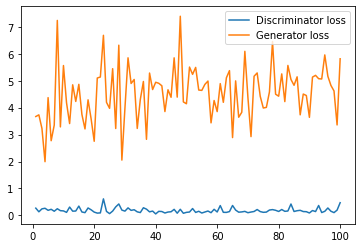

In [6]:
G, D = Generator(), Discriminator()
D.load_state_dict(torch.load('discriminator.pth'))
G.load_state_dict(torch.load('generator.pth'))

x = np.linspace(1,100,100)
plt.plot(x, d_losses, label='Discriminator loss')
plt.plot(x, g_losses, label='Generator loss')
plt.legend()
plt.show()

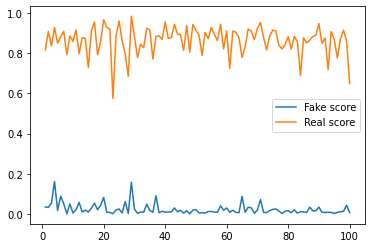

In [7]:
plt.plot(x, f_scores, label='Fake score')
plt.plot(x, r_scores, label='Real score')
plt.legend()
plt.show()

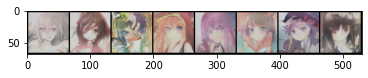

In [50]:
from torchvision import transforms
from PIL import Image

num_tests = 8
with torch.no_grad():
    test_latent = torch.randn(num_tests, 128, 1, 1).to(DEVICE)
    generated = G(test_latent) * 0.5 + 0.5
    save_image(generated, 'result.png')
    with Image.open('result.png') as im:
        result = np.array(im)
    plt.imshow(result)